https://www.youtube.com/watch?v=luiJttJVeBA&ab_channel=datadrenaline

https://www.youtube.com/watch?v=czd9a2Rc-h4&ab_channel=DataCamp

https://dockerlabs.collabnix.com/docker/cheatsheet/

https://mlconference.ai/blog/real-time-anomaly-detection-with-kafka-and-isolation-forests/?gclid=Cj0KCQjwqc6aBhC4ARIsAN06NmMN_ObP_nI-oxDgHQZq9jKOVwJFRe2lTLMkhpQgWJaPVVWH9RuOQjYaAplvEALw_wcB

https://medium.com/@sidjain1412/anomaly-detection-for-time-series-data-dc92a1d1a49f

https://medium.com/@alex.huang1117/how-to-detect-anomalies-without-labels-project-overview-9b91332201d5

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 




In [2]:
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local[*]').appName('spark_app').getOrCreate()
df = spark.read.csv('DBA80.csv', header=True,inferSchema=True, sep=';').orderBy('TimeStamp',ascending = True)

df = df.withColumn('ActualPos', regexp_replace('ActualPos', ',', '.'))
df = df.withColumn('ActualPos', df['ActualPos'].cast('double'))
df.printSchema()

pdf = df.toPandas()


root
 |-- TimeStamp: timestamp (nullable = true)
 |-- ActualPos: double (nullable = true)
 |-- ActualForce: integer (nullable = true)
 |-- Nahtnummer: string (nullable = true)
 |-- LaserPwr: integer (nullable = true)
 |-- Befehl: string (nullable = true)



In [3]:
pdf.head(10)


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636
5,2020-09-22 10:52:38.566,1.9,-693,KHO,376,PUTG348_46360631
6,2020-09-22 10:52:39.299,1.6,-691,KIG,376,PUTG348_46360630
7,2020-09-22 10:52:40.037,1.5,-705,KHP,375,PNB335
8,2020-09-22 10:52:40.431,-11.4,307,KHP,0,PNB343
9,2020-09-22 10:52:44.129,0.3,-688,FIPC,382,PUTG348_46360642


In [4]:
pdf.describe()


,ActualPos,ActualForce,LaserPwr
count,1000000.000000,1000000.000000,1000000.000000
mean,-8.174710,-574.953371,268.952781
std,136.541504,4021.754611,177.650401
min,-8192.000000,-151386.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-520.000000,396.000000
max,8191.900000,151388.000000,408.000000


In [5]:
q2 = 0.99
q1 = 0.01
multi = 1.5
q2_F = pdf.ActualForce.quantile(q2)
q1_F = pdf.ActualForce.quantile(q1)

iqr_F = q2_F-q1_F

q2_P = pdf.ActualPos.quantile(q2)
q1_P = pdf.ActualPos.quantile(q1)

iqr_P = q2_P-q1_P


pdf_clean = pdf[(pdf.ActualForce < q2_F+(multi*iqr_F)) & (pdf.ActualForce > q1_F-(multi*iqr_F)) & (pdf.ActualPos < q2_P+(multi*iqr_P)) & (pdf.ActualPos > q1_P-(multi*iqr_P))]

pdf_clean.describe()


,ActualPos,ActualForce,LaserPwr
count,999029.000000,999029.000000,999029.000000
mean,-9.643305,-514.509987,269.190766
std,25.166300,373.544499,177.549117
min,-72.800000,-1922.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-520.000000,396.000000
max,22.300000,718.000000,408.000000


In [8]:
pdf_clean.groupby('Befehl').count().reset_index().sort_values('TimeStamp',ascending=False)s

,Befehl,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr
90,PUTG348_46360638,53644,53644,53644,53644,53644
77,PUTG348_46360610,45044,45044,45044,45044,45044
92,PUTG348_46360641,44776,44776,44776,44776,44776
78,PUTG348_46360622,44522,44522,44522,44522,44522
84,PUTG348_46360632,44202,44202,44202,44202,44202
...,...,...,...,...,...,...
39,PNB320,1,1,1,1,1
53,PNB42,1,1,1,1,1
118,PUTG463_46360775,1,1,1,1,1
120,PUTG463_46360778,1,1,1,1,1


<AxesSubplot: xlabel='TimeStamp', ylabel='Befehl'>

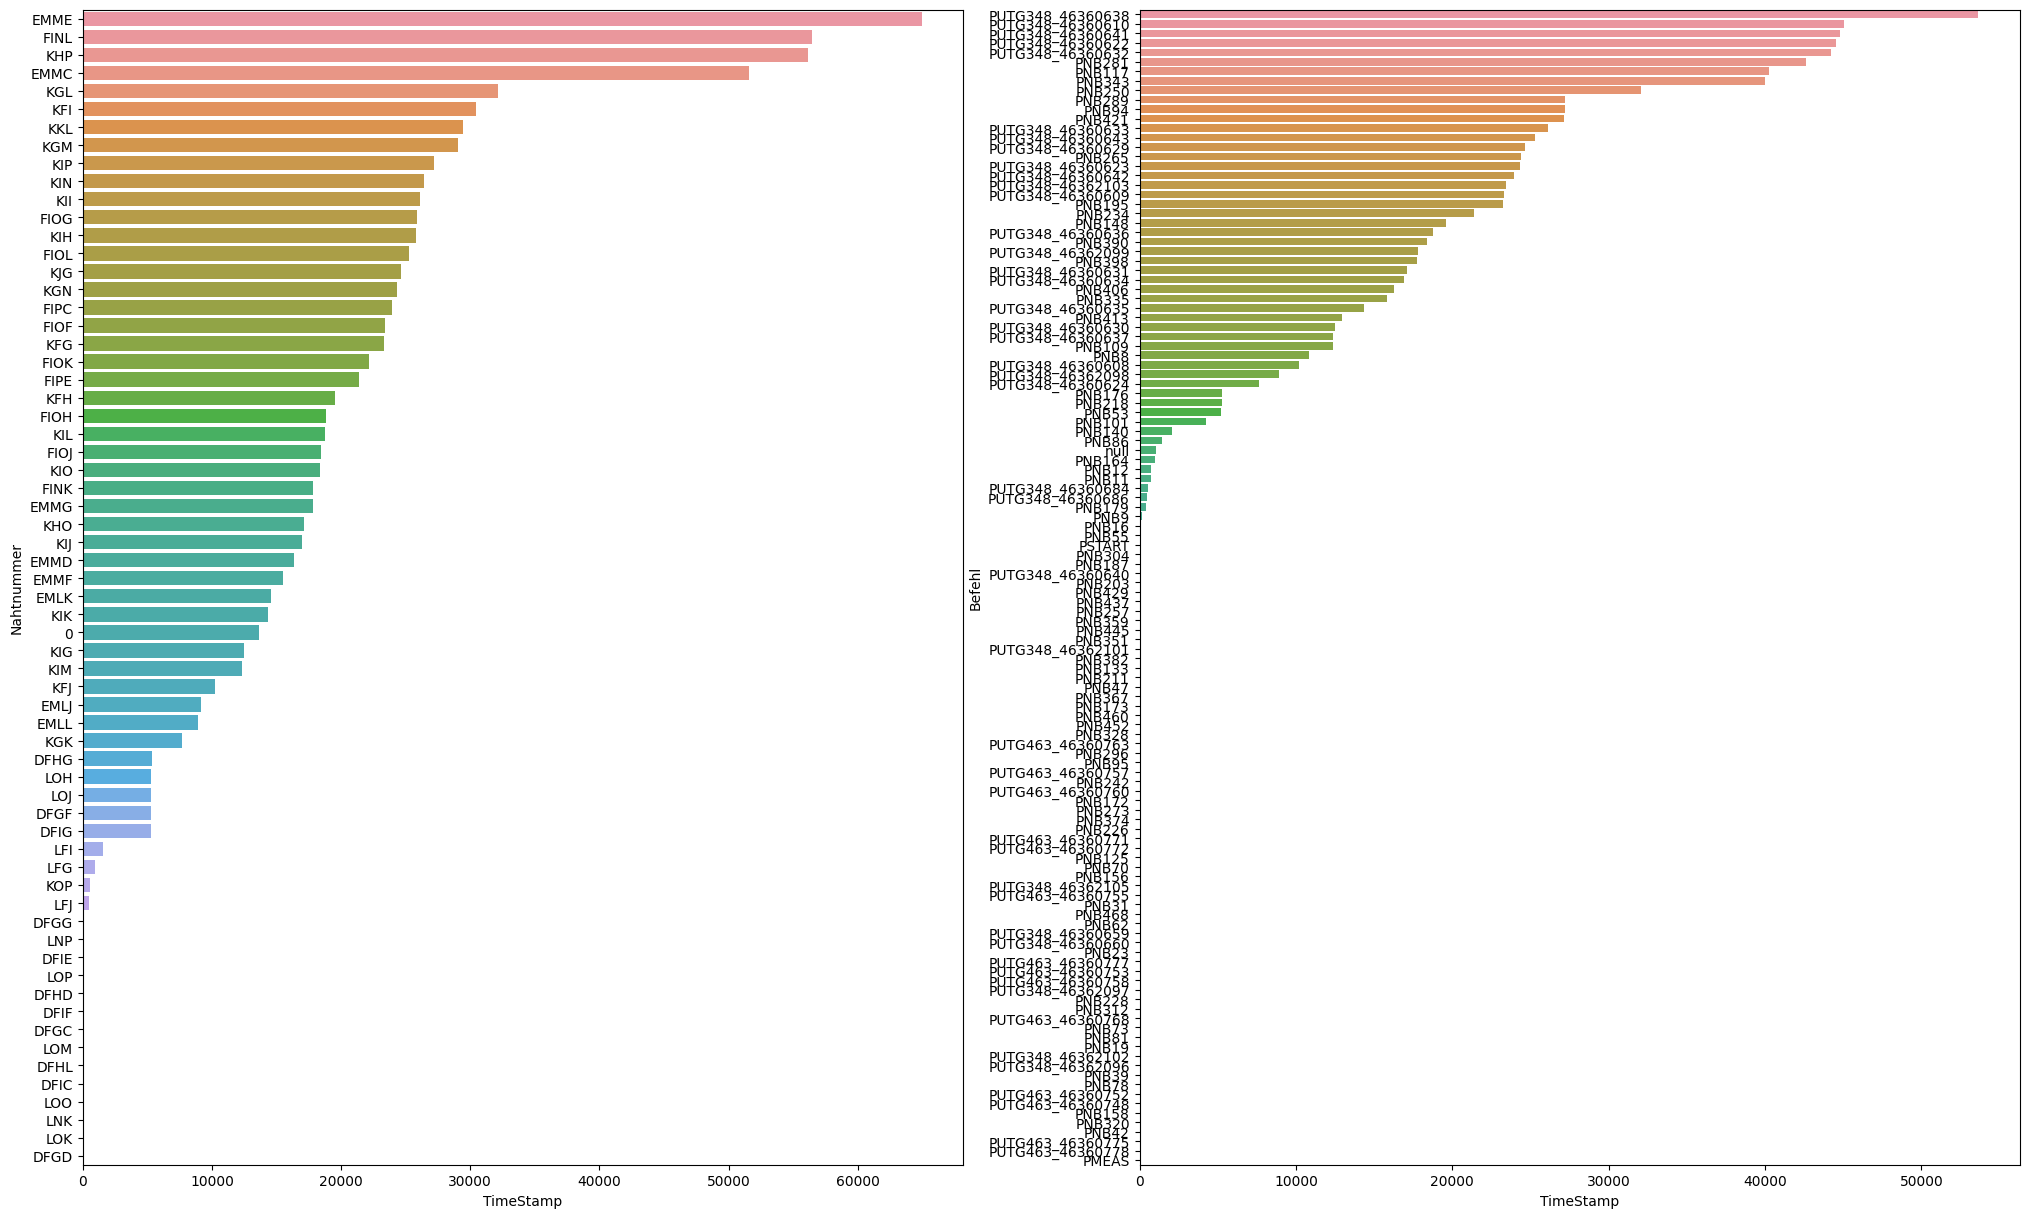

In [6]:
fig,ax = plt.subplots(1,2,figsize=(25,15))
sns.barplot(data=pdf_clean.groupby('Nahtnummer').count().reset_index().sort_values(
    'TimeStamp', ascending=False), y='Nahtnummer', x='TimeStamp', ax=ax[0])
sns.barplot(data=pdf_clean.groupby('Befehl').count().reset_index().sort_values('TimeStamp', ascending=False),
            y='Befehl', x='TimeStamp', ax=ax[1])


In [50]:
pvtble=pdf_clean.pivot_table(index='Befehl',columns='Nahtnummer',values='ActualPos',aggfunc='count')

In [51]:
pvtble

Nahtnummer,0,DFGC,DFGD,DFGF,DFGG,DFHD,DFHG,DFHL,DFIC,DFIE,...,LFI,LFJ,LNK,LNP,LOH,LOJ,LOK,LOM,LOO,LOP
Befehl,,,,,,,,,,,,,,,,,,,,,
PMEAS,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNB101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4232.0,NaN,NaN,NaN,NaN,NaN
PNB109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1061.0,NaN,NaN,NaN,1.0,NaN
PNB11,721.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNB117,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,1.0,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PUTG463_46360772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PUTG463_46360775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PUTG463_46360777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: ylabel='Befehl'>

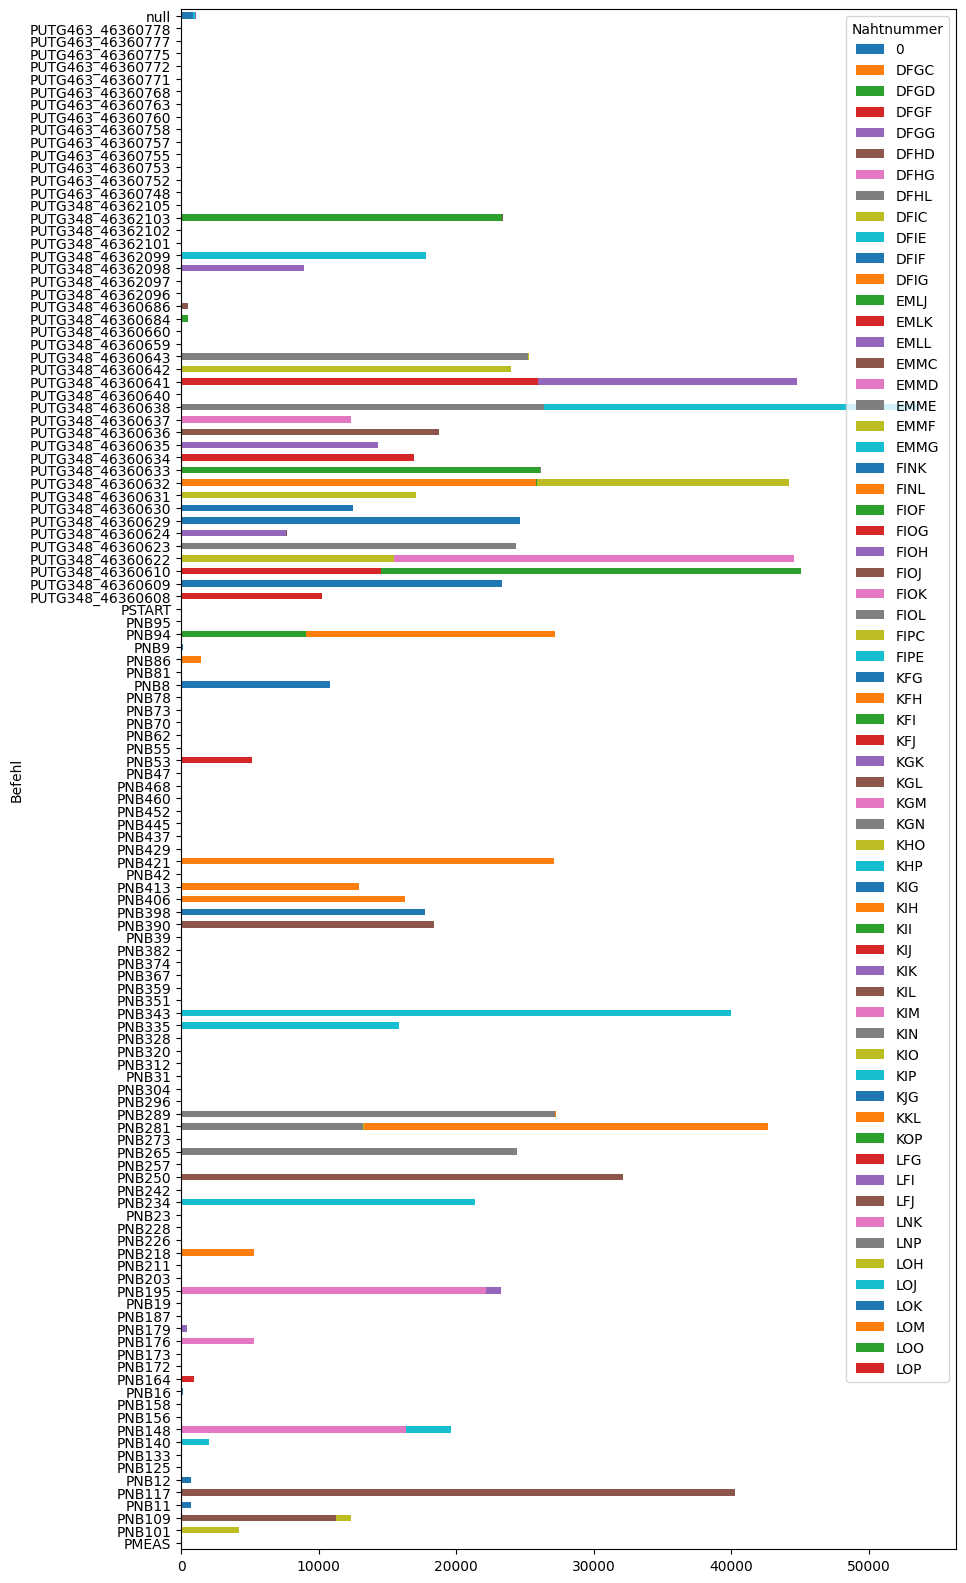

In [52]:

pvtble.plot(kind='barh',stacked=True, figsize=(10,20))

(-936.0, 266.0)
(0.6, 14.0)


<AxesSubplot: xlabel='ActualPos', ylabel='ActualForce'>

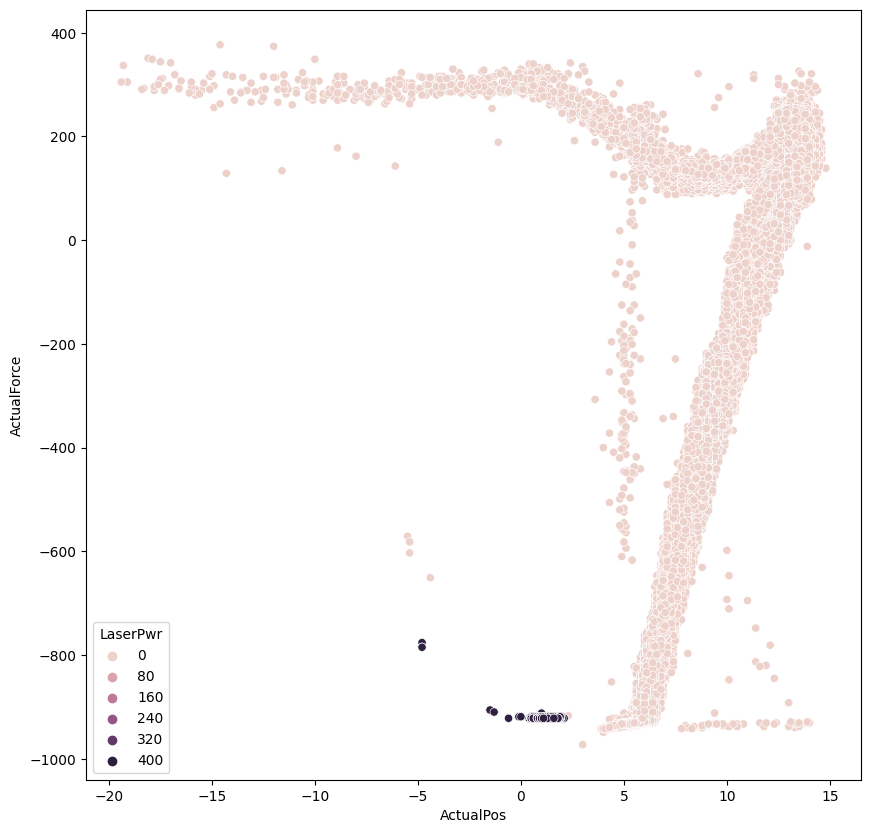

In [14]:

pdf_n=pdf[(pdf.Nahtnummer == 'EMME')]

q2=0.99
q1=0.01
multi=1.5
q2_F = pdf_n.ActualForce.quantile(q2)
q1_F = pdf_n.ActualForce.quantile(q1)

iqr_F=q2_F-q1_F

q2_P = pdf_n.ActualPos.quantile(q2)
q1_P = pdf_n.ActualPos.quantile(q1)

iqr_P = q2_P-q1_P

print((q1_F,q2_F))
print((q1_P, q2_P))

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=pdf_n[(pdf_n.ActualForce < q2_F+(multi*iqr_F)) & (pdf_n.ActualForce > q1_F-(multi*iqr_F)) &
                           (pdf_n.ActualPos < q2_P+(multi*iqr_P)) & (pdf_n.ActualPos > q1_P-(multi*iqr_P))], x='ActualPos', y='ActualForce', hue='LaserPwr')


<AxesSubplot: xlabel='ActualPos', ylabel='Count'>

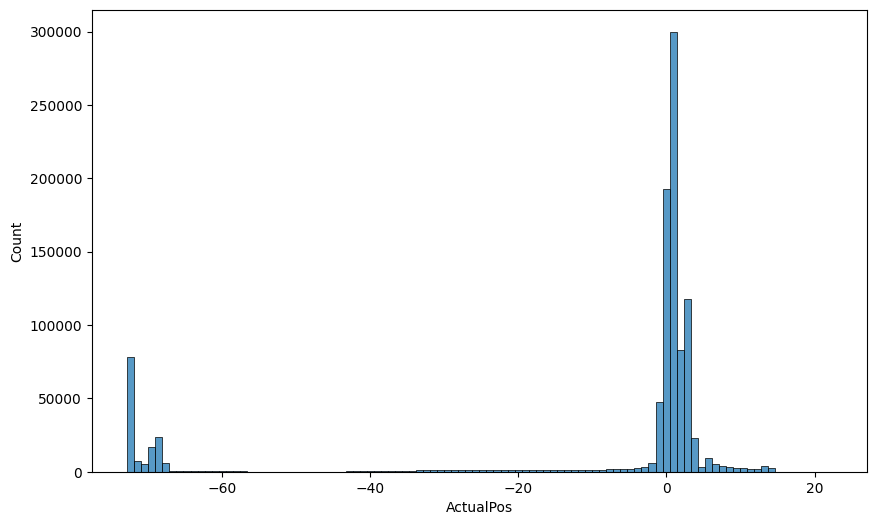

In [7]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean,x='ActualPos', bins=100)

<AxesSubplot: xlabel='ActualForce', ylabel='Count'>

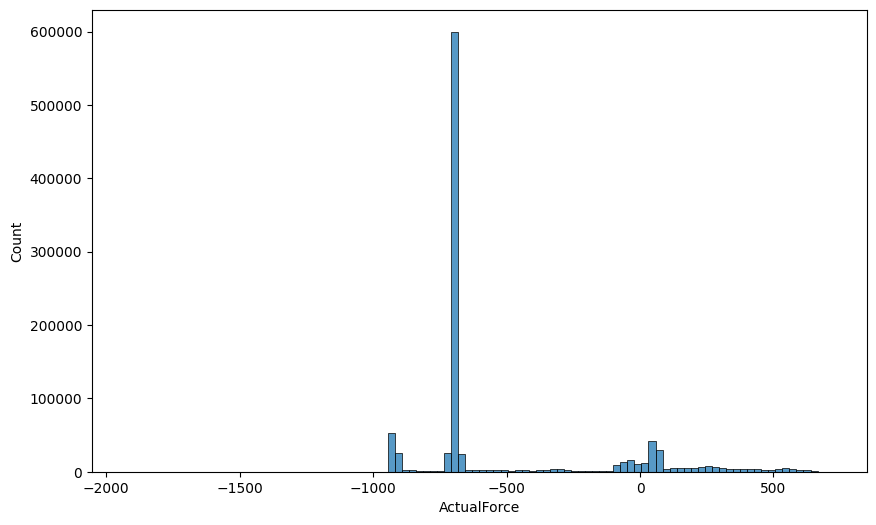

In [9]:
fig = plt.figure(figsize=(10,6))
sns.histplot(data=pdf_clean, x='ActualForce', bins=100)

<AxesSubplot: xlabel='LaserPwr', ylabel='Count'>

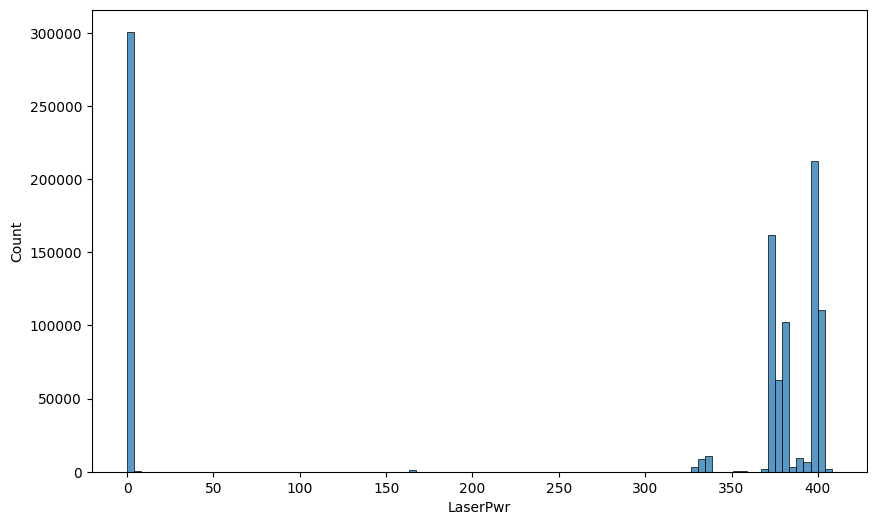

In [11]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean, x='LaserPwr', bins=100)


<AxesSubplot: xlabel='TimeStamp', ylabel='Date'>

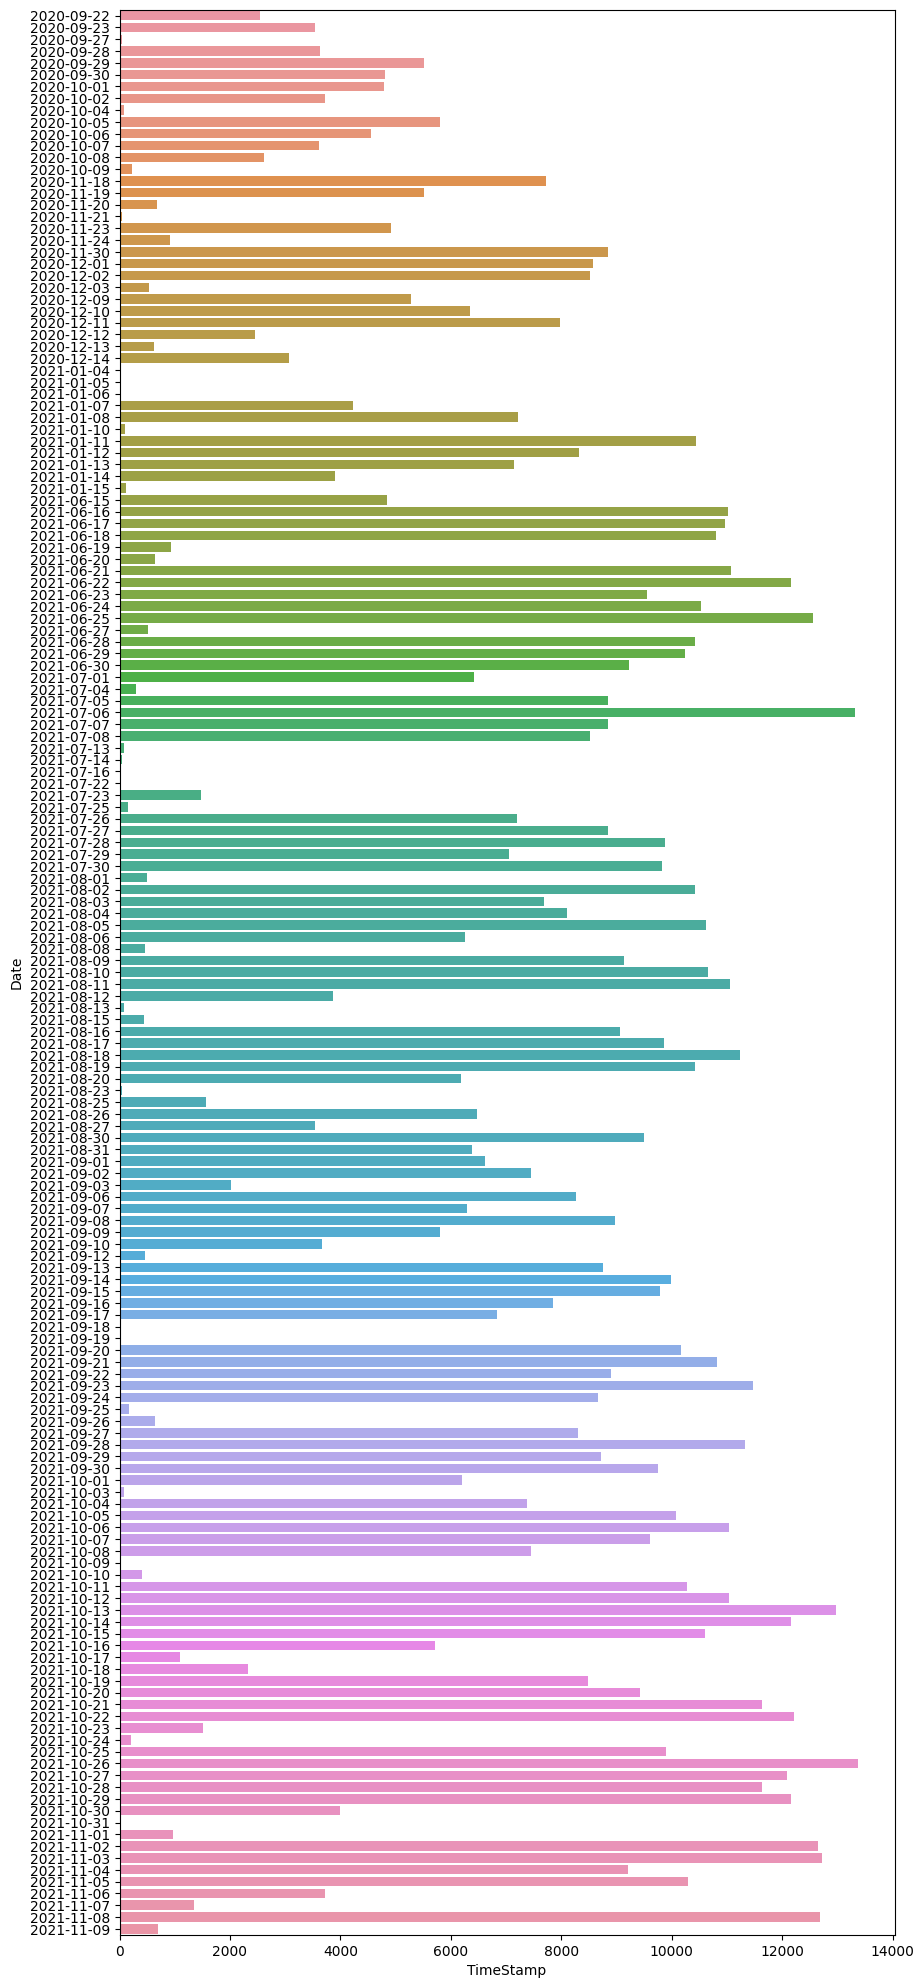

In [37]:

fig = plt.figure(figsize=(10, 25))
sns.barplot(data=pdf.groupby('Date').count().reset_index(),x='TimeStamp',y='Date')


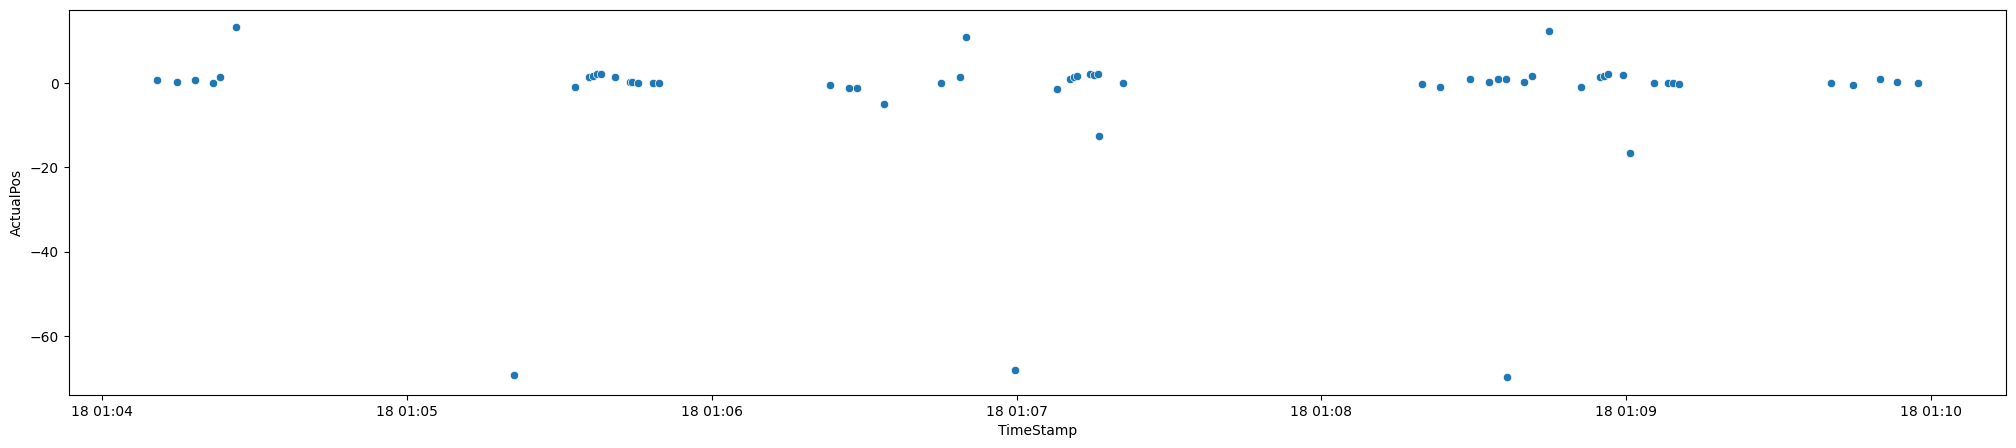

In [82]:

fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='ActualPos')
#g.set(yscale='log')


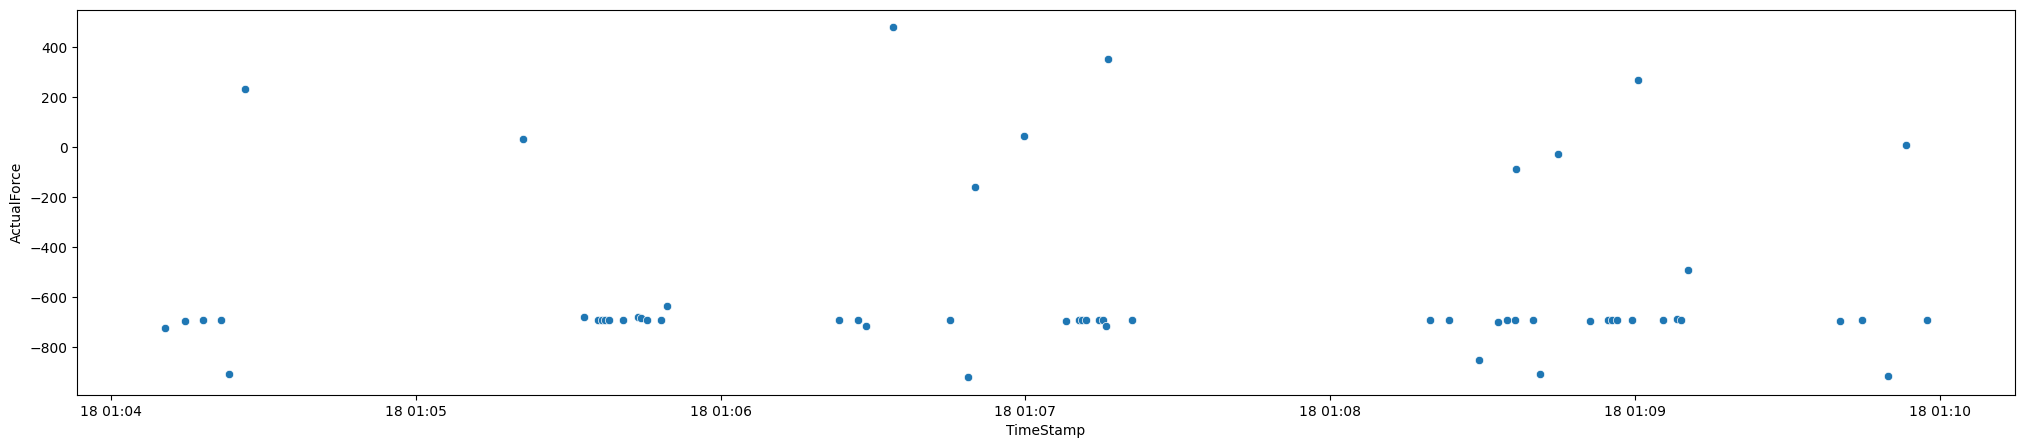

In [80]:
fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='ActualForce')


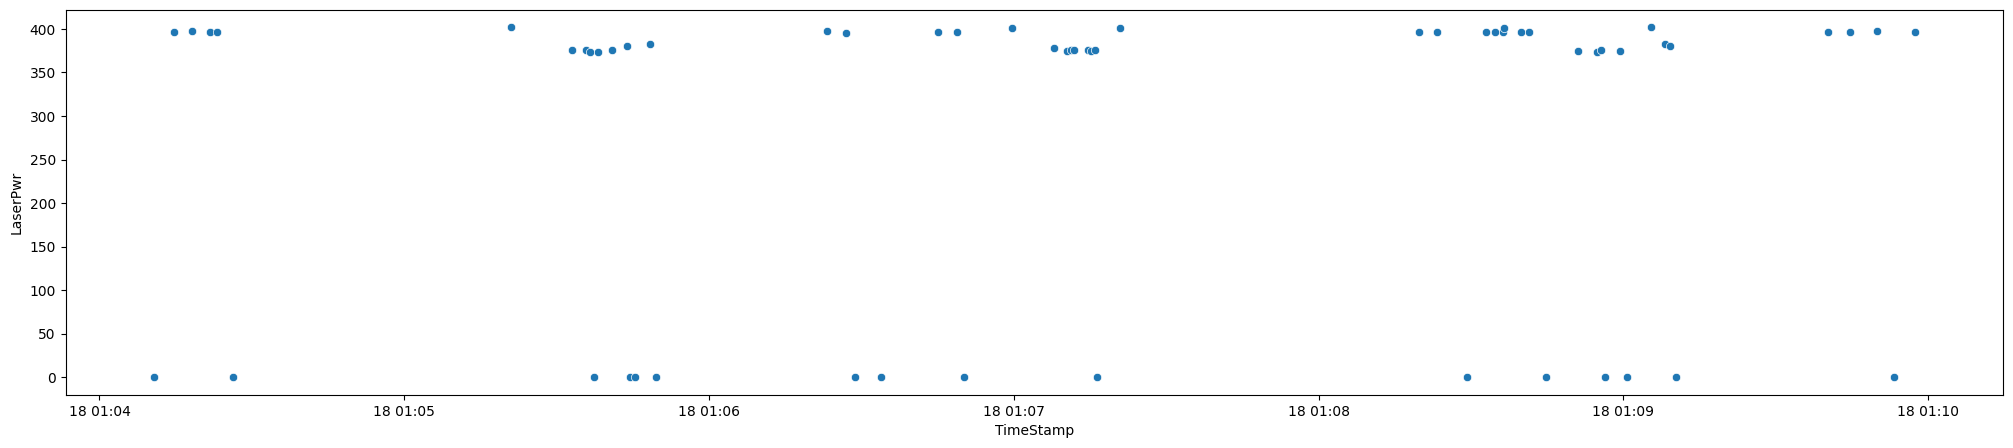

In [79]:
fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='LaserPwr')


In [87]:
pdf[(pdf.TimeStamp>"2020-11-18 01:00:00")&(pdf.TimeStamp<"2020-11-18 01:30:00")]

,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl,Date
45489,2020-11-18 01:04:10.675,0.8,-725,EMMC,0,PNB117,2020-11-18
45490,2020-11-18 01:04:14.596,0.4,-698,EMMF,397,PUTG348_46360622,2020-11-18
45491,2020-11-18 01:04:18.140,0.8,-693,KGN,398,PUTG348_46360623,2020-11-18
45492,2020-11-18 01:04:21.693,0.1,-691,KGL,397,PNB250,2020-11-18
45493,2020-11-18 01:04:23.143,1.6,-908,EMMG,396,PUTG348_46362099,2020-11-18
...,...,...,...,...,...,...,...
45570,2020-11-18 01:22:08.945,0.9,-691,KGM,397,PUTG348_46360622,2020-11-18
45571,2020-11-18 01:22:10.303,0.9,-691,KGN,396,PUTG348_46360623,2020-11-18
45572,2020-11-18 01:22:14.206,0.1,-691,KGL,397,PNB250,2020-11-18
45573,2020-11-18 01:22:17.947,1.3,-922,EMME,398,PNB265,2020-11-18


In [100]:
pdf[pdf.ActualPos > 1].describe()


,ActualPos,ActualForce,LaserPwr
count,352036.000000,352036.000000,352036.000000
mean,8.100295,-781.437552,270.763496
std,206.507095,4231.035632,170.845625
min,1.100000,-151386.000000,0.000000
25%,1.400000,-693.000000,0.000000
50%,2.400000,-691.000000,375.000000
75%,3.000000,-688.000000,378.000000
max,8191.900000,621.000000,405.000000
